In [18]:
#Author:Guo-hua Yuan
#Unit:CAS-MPG Partner Institute for Computational Biology, Shanghai Institutes for Biological Sciences, Chinese Academy of Sciences, Shanghai, China
#Mail:yuanguohua@sibs.ac.cn
#Date:2020.11.16

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import copy
import warnings
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader

In [2]:
help(torch.tensor)

Help on built-in function tensor:

tensor(...)
    tensor(data, dtype=None, device=None, requires_grad=False, pin_memory=False) -> Tensor
    
    Constructs a tensor with :attr:`data`.
    
    .. warning::
    
        :func:`torch.tensor` always copies :attr:`data`. If you have a Tensor
        ``data`` and want to avoid a copy, use :func:`torch.Tensor.requires_grad_`
        or :func:`torch.Tensor.detach`.
        If you have a NumPy ``ndarray`` and want to avoid a copy, use
        :func:`torch.as_tensor`.
    
    .. warning::
    
        When data is a tensor `x`, :func:`torch.tensor` reads out 'the data' from whatever it is passed,
        and constructs a leaf variable. Therefore ``torch.tensor(x)`` is equivalent to ``x.clone().detach()``
        and ``torch.tensor(x, requires_grad=True)`` is equivalent to ``x.clone().detach().requires_grad_(True)``.
        The equivalents using ``clone()`` and ``detach()`` are recommended.
    
    Args:
        data (array_like): Initial d

In [20]:
# Superparameters 
# Set up GPU device and random seed.
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 2019
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Default data loader parameters
DATA_LOADER_PARAMS = {
    "batch_size":32,
    "shuffle": True,
    "num_workers": 1,
}

OPTIMIZER_PARAMS = {
    "lr": 1e-3,
}

ModelPerf = collections.namedtuple(
    'ModelPerf',
    ['auroc', 'auroc_curve', 'auprc', 'auprc_curve', 'accuracy', 'recall', 'precision', 'f1', 'class_report','ce_loss'],
)

In [21]:
# CNN model
class Basset_CNN(nn.Module):
    """ Similar to Basset model, 
    This model is "shallower" than factorized basset, 
    but has larger convolutions that may be able to pick up longer motifs.
    """
    def __init__(self, dropout, num_classes):
        super(Basset_CNN, self).__init__()
        self.dropout = dropout

        self.conv1 = nn.Conv2d(4, 300, (19, 1), stride = (1, 1), padding=(9,0))
        self.conv2 = nn.Conv2d(300, 200, (11, 1), stride = (1, 1), padding = (5,0))
        self.conv3 = nn.Conv2d(200, 200, (7, 1), stride = (1, 1), padding = (4,0))

        self.bn1 = nn.BatchNorm2d(300)
        self.bn2 = nn.BatchNorm2d(200)
        self.bn3 = nn.BatchNorm2d(200)
        self.maxpool1 = nn.MaxPool2d((3, 1))
        self.maxpool2 = nn.MaxPool2d((4, 1))
        self.maxpool3 = nn.MaxPool2d((4, 1))

        self.fc1 = nn.Linear(4200, 1000)
        self.bn4 = nn.BatchNorm1d(1000)

        self.fc2 = nn.Linear(1000, 1000)
        self.bn5 = nn.BatchNorm1d(1000)

        self.fc3 = nn.Linear(1000, num_classes)

    def forward(self, s):
        s = s.unsqueeze(-1)                                          # batch_size x 1000 x 4 x 1 [4 channels]
        s = s.permute(0, 2, 1, 3).contiguous()                       # batch_size x 4 x 1000 x 1（dimensions permuted）
        s = self.maxpool1(F.relu(self.bn1(self.conv1(s))))          # batch_size x 300 x 333 x 1
        s = self.maxpool2(F.relu(self.bn2(self.conv2(s))))          # batch_size x 200 x 83 x 1
        s = self.maxpool3(F.relu(self.bn3(self.conv3(s))))          # batch_size x 200 x 21 x 1
        s = s.view(-1, 4200)
        

        s = F.dropout(F.relu(self.bn4(self.fc1(s))), p=self.dropout, training=self.training)  # batch_size x 1000
        s = F.dropout(F.relu(self.bn5(self.fc2(s))), p=self.dropout, training=self.training)  # batch_size x 1000
        intermediate_out = s
        
        s = self.fc3(s)
        s = torch.sigmoid(s)

        return s, intermediate_out

In [22]:
# Early stop for model
class EarlyStopper(object):
    """
    Helper class that monitors a given metric and determines if training should continue
    Namely, stops training after we have gone <patience> epochs without an improvement
    """
    def __init__(self, metric='auroc', patience=3, mode='max', verbose=False):
        self.metric = metric
        self.mode = mode
        self.patience = patience
        self.verbose = verbose
        self.metric_values = []

    def record_epoch(self, model_perf):
        """Return True if training should stop"""
        self.metric_values.append(model_perf._asdict()[self.metric])
        best_epoch = np.argmax(self.metric_values) if self.mode == 'max' else np.argmin(self.metric_values)
        # If best epoch was first epoch, and we are on second epoch, this evaluates to
        # 2 - 0 - 1 = 1 epochs without improvement
        # If best epocvh was second epoch, and we are on 5th epoch, this evaluates to
        # 5 - 1 - 1 = 3 epochs without improvement
        epochs_without_improvement = len(self.metric_values) - best_epoch - 1
        if epochs_without_improvement >= self.patience:
            if self.verbose:
                print(f"{epochs_without_improvement} epochs without improvement - sending signal to stop training")
            return True
        return False

In [23]:
# Dataset
class MyDataset(Dataset):
    #Format of data is a pandas dataframe splitted by "train_test_split"
    def __init__(self,data):
        self.data = data
        self.tensor_list = self.to_tensor_list(self.data)
        self.size = len(self.tensor_list)
        
    def __len__(self):
        return self.size
    
    def __getitem__(self,idx):
        sequence = self.tensor_list[idx][0]
        label = self.tensor_list[idx][1]
        return sequence,label
    
    @staticmethod
    def to_tensor_list(data):
        data = data.reset_index(drop = True)
        tensor_list = []
        NT_dict = {'A':[1,0,0,0],'U':[0,1,0,0],'G':[0,0,1,0],'C':[0,0,0,1],'N':[0,0,0,0]}
        tag_dict = {'0': 0, '1':1}
        for i in range(len(data)):
            seq_tensor = torch.tensor([ NT_dict[j] for j in data.loc[i,"cdna"]],dtype=torch.float32)
            label_tensor = torch.tensor(tag_dict[str(data.loc[i,"tag"])],dtype=torch.float32)
            tensor_list.append([seq_tensor,label_tensor])
        return tensor_list

In [24]:
# Whether in jupyter notebook
def isnotebook() -> bool:
    """
    Returns True if the current execution environment is a jupyter notebook
    https://stackoverflow.com/questions/15411967/how-can-i-check-if-code-is-executed-in-the-ipython-notebook
    """
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

In [25]:
# Get input files
def get_files():
    input_f1 = sys.argv[1]
    input_f2 = sys.argv[2]
    return input_f1,input_f2

In [26]:
# Train pytorch model
def pytorch_train(net, train_data, valid_data, max_epochs=30, early_stop_patience=3, loss=nn.BCELoss,data_loader_kwargs=DATA_LOADER_PARAMS, optim_kwargs=OPTIMIZER_PARAMS,optim=torch.optim.Adam, verbose=True, progressbar=False,device = DEVICE):
    """
    Train the given pytorch model.
    Return the performance at the end of every epoch, as well as the path to each epoch checkpoint
    """
    
    if data_loader_kwargs is not None:  # If this is none, then we don't use the DataLoader wrapper
        train_loader = DataLoader(train_data, **data_loader_kwargs)
    
    net.to(device)
    criterion = loss()
    optimizer = optim(net.parameters(), **optim_kwargs)
    early_stopper = EarlyStopper(patience=early_stop_patience)

    epoch_dicts = []
    np.random.seed(2020)
    for epoch in range(max_epochs):
        running_loss = 0.0  # Tracks the average loss at each epoch
        num_examples = 0
        for local_batch, local_labels in train_loader:
            # Transfer to GPU
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            # Zero out gradients
            optimizer.zero_grad()
            # Forward + backward + optimize
            local_outputs = net(local_batch)
            if isinstance(local_outputs, tuple):
                local_outputs = local_outputs[0]  # If there are multiple return values, assume first output is target for loss func
            loss = criterion(torch.squeeze(local_outputs), torch.squeeze(local_labels))
            loss.backward()
            optimizer.step()

            num_examples += local_outputs.shape[0]
            running_loss += loss.item()
        # Evaluate validation loss per epoch
        valid_overall_perf, valid_per_class_perf, _valid_truths, _valid_preds = pytorch_eval(net, valid_data, data_loader_kwargs=data_loader_kwargs)
        amortized_loss = running_loss / float(num_examples)
        if verbose:
            print(f"Train loss:          {amortized_loss}")
            print(f"Valid loss:          {valid_overall_perf.ce_loss}")
            print("Validation accuracy: {}".format(valid_overall_perf.accuracy))
            print("Validation F1:       {}".format(valid_overall_perf.f1))
            print("Validation AUPRC:    {}".format(valid_overall_perf.auprc))
            print("Validation AUROC:    {}".format(valid_overall_perf.auroc))
        epoch_dict = {
            'epoch': epoch,
            'model_state_dict': copy.deepcopy(state_dict_to_cpu(net.state_dict())),
            # 'optimizer_state_dict': copy.deepcopy(optimizer.state_dict()),
            'train_loss': amortized_loss,
            'valid_loss': valid_overall_perf.ce_loss,
            'auroc': valid_overall_perf.auroc,
            'auprc': valid_overall_perf.auprc,
        }
        epoch_dicts.append(epoch_dict)

        if early_stopper.record_epoch(valid_overall_perf):
            break  # Stop if we've gone several epochs without improvement on validation set

    # Find epoch with the best auroc
    auroc_vals = [p['auroc'] for p in epoch_dicts]
    best_auroc_index = np.argmax(auroc_vals)
    print("Epoch (1-index) with best AUROC: {}".format(best_auroc_index + 1))
    print("AUROC: {}".format(epoch_dicts[best_auroc_index]['auroc']))
    print("AUPRC: {}".format(epoch_dicts[best_auroc_index]['auprc']))

    return epoch_dicts,best_auroc_index

In [27]:
# Evaluate pytorch model
def pytorch_eval(net, eval_data, preds_index=0, data_loader_kwargs=DATA_LOADER_PARAMS, device=DEVICE):
    """Takes a model and a Dataset and evaluates"""
    data_loader = DataLoader(eval_data, **data_loader_kwargs)
    net.to(device)
    net.eval()
    truths, preds = [], []
    for batch, labels in data_loader:
        truths.extend(labels.numpy())
        batch, labels = batch.to(device), labels.to(device)
        outputs= net(batch)
        if isinstance(outputs, tuple):
            outputs = outputs[preds_index]  # If mulitiple outputs assume the first is the target for loss
        preds.extend(outputs.detach().cpu().numpy())
    truths = np.round(np.vstack(truths)).astype(int)
    preds = np.array(preds).astype(float)

    assert np.alltrue(preds <= 1.0) and np.alltrue(preds >= 0.0), "Found predicted probs outside of [0, 1]"
    assert truths.shape == preds.shape, f"Got mismatched shapes: {truths.shape} {preds.shape}"
    is_multitask = len(truths.shape) > 1 and truths.shape[1] > 1
    overall_perf = generate_model_perf(truths, preds,multiclass=is_multitask) #######
    per_class_perf = generate_multiclass_perf(truths, preds, num_classes=truths.shape[1]) if is_multitask else None

    net.train()
    return overall_perf, per_class_perf,truths, preds


In [28]:
# Get model performance
def generate_model_perf(truths, pred_probs,multiclass=False):
    """Given truths, and predicted probabilities, generate ModelPerf object"""
    pred_classes = np.round(pred_probs).astype(int)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        retval = ModelPerf(
            auroc=metrics.roc_auc_score(truths, pred_probs),
            auroc_curve=metrics.roc_curve(truths, pred_probs) if not multiclass else None ,
            auprc=metrics.average_precision_score(truths, pred_probs) ,
            auprc_curve=metrics.precision_recall_curve(truths, pred_probs) if not multiclass else None ,
            accuracy=metrics.accuracy_score(truths, pred_classes) if not multiclass else None ,
            recall=metrics.recall_score(truths, pred_classes) if not multiclass else None,
            precision=metrics.precision_score(truths, pred_classes) if not multiclass else None,
            f1=metrics.f1_score(truths, pred_classes)if not multiclass else None,
            class_report=metrics.classification_report(truths, pred_classes,target_names = ["nuc","cyto"]) if not multiclass else None,
            ce_loss=metrics.log_loss(truths, pred_probs, normalize=False) / np.prod(truths.shape),
        )
    return retval

In [29]:
# Get multiclass task model performance
def generate_multiclass_perf(truths, pred_probs, num_classes):
    """Given truths, return a list of ModelPerf objects, one for each class"""
    per_class_perfs = []
    for class_index in range(num_classes):
        if isinstance(pred_probs, list):
            preds = pred_probs[class_index][:, 1]
        else:
            preds = pred_probs[:, class_index]  # Handles OneVsRestClassifier output of (n_samples, n_classes)
        perf = generate_model_perf(truths[:, class_index].flatten(), preds)
        per_class_perfs.append(perf)
    return per_class_perfs

In [30]:
# Transfer the state dict to CPU
def state_dict_to_cpu(d):
    """Transfer the state dict to CPU. Avoids lingering GPU memory buildup."""
    retval = collections.OrderedDict()
    for k, v in d.items():
        retval[k] = v.cpu()
    return retval

In [31]:
# Trancate or padding sequnce to 1000nt(3' bias)
def fix_seq(seq):
    length = len(seq)
    #padding N on upstream of 5' end  NNNNNATCGAACCCT...CAGCCCG(1000nt)
    if length < 1000:
        seq = (1000-length)*'N' + seq
    #trancate to 1000nt from 3' end  ATCG...CC|AA...ACTCTCCCAG(1000nt)
    else:
        seq = seq[-1000:]
    return seq

In [32]:
# Output result of evaluation
def eval_output(model_perf,output_file):
    with open(output_file,'w') as f:
        f.write("AUROC=%s\tAUPRC=%s\tAccuracy=%s\tRecall=%s\tPrecision=%s\tf1_score=%s\n" %
               (model_perf[0],model_perf[2],model_perf[4],model_perf[5],model_perf[6],model_perf[7]))
        f.write("\n######NOTE#######\n")
        f.write("#According to help_documentation of sklearn.metrics.classification_report:in binary classification, recall of the positive class is also known as sensitivity; recall of the negative class is specificity#\n\n")
        f.write(model_perf[8])

In [33]:
# Plot ROC of models
def plot_ROC(model_perf,output_file):
    #get AUC,FPR,TPR and threshold
    roc_auc = model_perf[0]
    fpr,tpr,threshold = model_perf[1]
    #plot
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC (area = %0.2f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC of Models')
    plt.legend(loc="lower right")
    plt.savefig(output_file,format = "pdf")

count    494792.000000
mean        248.160298
std          15.176095
min         126.000000
5%          251.000000
25%         251.000000
50%         251.000000
75%         251.000000
95%         251.000000
max         251.000000
Name: cdna, dtype: float64


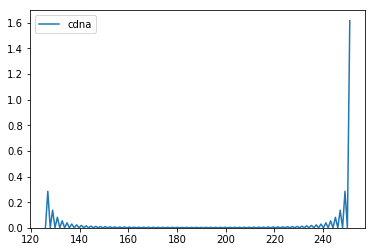

In [34]:
if __name__ == "__main__":  
    ##################################
    
    #Data Processing
    
    # get input_file path
    if isnotebook():
        neg_f = "/home/lilabguest2/shenhaoyu/negative_m6A.csv"
        pos_f = "/home/lilabguest2/shenhaoyu/positive_m6A.csv"
    else:
        neg_f,pos_f = get_files()
    # load data
    dataset_neg = pd.read_csv(neg_f,sep=',')
    dataset_pos = pd.read_csv(pos_f,sep=',')
    # set tag(label) : neg 0 / pos 1
    dataset_neg['tag'] = 0;dataset_pos['tag'] = 1
    # merge the nuc and cyto dataset
    dataset = pd.concat([dataset_neg,dataset_pos],ignore_index = True)
    # remove duplicated
    dataset.drop_duplicates(keep='first',inplace=True) 
    dataset = dataset.reset_index(drop = True)
    #distribution of length of lncRNA
    length_set = dataset["cdna"].apply(len)
    sns.kdeplot(length_set)
    print(length_set.describe(percentiles=[.05, .25, .75, .95]))
    #Rebuild dataset with fixed length (1000nt,3' bias)
    dataset["cdna"] = dataset["cdna"].apply(fix_seq)
    dataset=dataset.dropna()
    #dataset=dataset.sample(n=420)
    # split the train,validate and test (~ 7:2:1)
    data_train_validate, data_test = train_test_split(dataset.loc[:,['cdna','tag']], test_size = 0.1, random_state = 100)
    data_train,data_validate = train_test_split(data_train_validate, test_size = 0.2, random_state = 100)


Train loss:          0.008590975171111525
Valid loss:          0.25461263243061644
Validation accuracy: 0.909569630486285
Validation F1:       0.0022299306243805748
Validation AUPRC:    0.2921267350252098
Validation AUROC:    0.7987955345481493
Train loss:          0.0079099518551694
Valid loss:          0.25416683057111106
Validation accuracy: 0.9096145425148491
Validation F1:       0.00910881339241753
Validation AUPRC:    0.2838769445140089
Validation AUROC:    0.7974920709290877
Train loss:          0.0076325991311013515
Valid loss:          0.248190768389154
Validation accuracy: 0.9093675263577468
Validation F1:       0.1376068376068376
Validation AUPRC:    0.31219237130723315
Validation AUROC:    0.8168527299675549
Train loss:          0.007281269266624575
Valid loss:          0.24965227379081167
Validation accuracy: 0.9095022624434389
Validation F1:       0.1420055354481584
Validation AUPRC:    0.3101133905692949
Validation AUROC:    0.8120384747888159
Train loss:          0.0066

<Figure size 432x288 with 0 Axes>

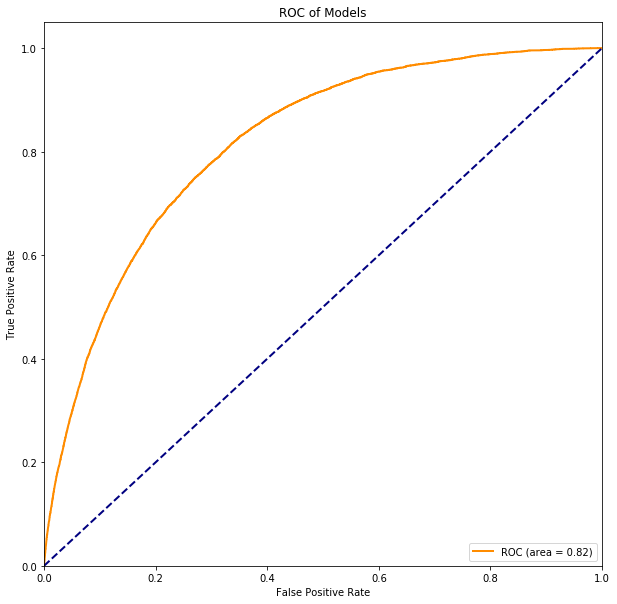

<Figure size 432x288 with 0 Axes>

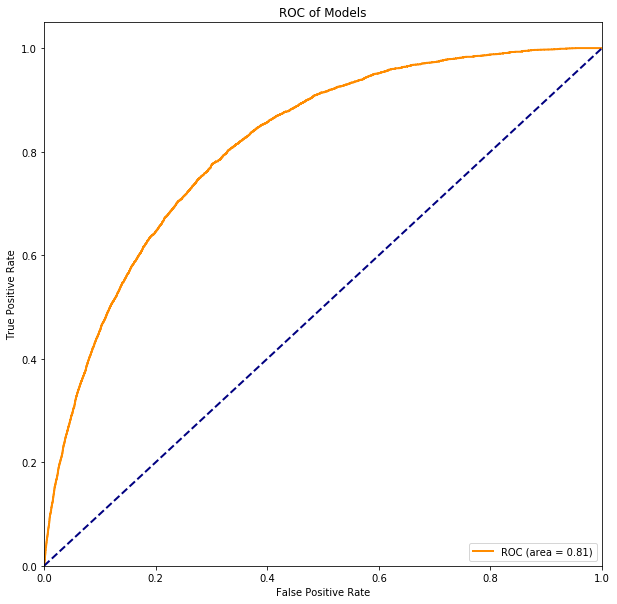

In [35]:
    #convert to Dataset
    TrainSet = MyDataset(data_train)
    ValidateSet = MyDataset(data_validate)
    TestSet = MyDataset(data_test)
    
    ##################################
    
    # Construct and Evaluate Model
    
    #New model
    Net = Basset_CNN(dropout = 0.3,num_classes = 1)
    #train model and evaluate model by ValidateSet
    model_dict,best_auroc_index = pytorch_train(Net,TrainSet,ValidateSet)
    #save best model based ValidateSet_auroc(You can also look at verbose)
    torch.save(model_dict[best_auroc_index]["model_state_dict"], './Basset_CNN_1000nt_best_model.parameter.pkl')
    #load model
    best_model = Basset_CNN(dropout = 0.3,num_classes = 1)
    best_model.load_state_dict(torch.load('Basset_CNN_1000nt_best_model.parameter.pkl'))
    #evaluate performance of best_model by ValidateSet and TestSet
    overall_perf_V, per_class_perf_V,truths_V, preds_V = pytorch_eval(best_model,ValidateSet)
    overall_perf_T, per_class_perf_T,truths_T, preds_T = pytorch_eval(best_model,TestSet)
    
        
    ##################################
    
    # Output
    
    #output result of evaluation
    eval_output(overall_perf_V,"./Evaluate_Result_ValidateSet.txt")
    eval_output(overall_perf_T,"./Evaluate_Result_TestSet.txt")
    # plot ROC_ValidateSet ROC_TestSet
    plot_ROC(overall_perf_V,"./ROC_ValidateSet.pdf")
    plot_ROC(overall_perf_T,"./ROC_TestSet.pdf")
    
    ##################################